In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import tensorflow_hub as hub
import tensorflow_text
import warnings
from sentence_transformers import SentenceTransformer
warnings.filterwarnings('ignore')
from transformers import TFBertTokenizer, TFBertModel, BertTokenizer
import tqdm 
import unicodedata
import pickle
import re

2023-11-30 23:28:46.933396: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 23:28:46.959606: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 23:28:46.959633: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 23:28:46.959660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 23:28:46.965970: I tensorflow/core/platform/cpu_feature_g

In [2]:
with open('data_frame_object_with_all_embeddings_cleaned', 'rb') as file:
    df = pickle.load(file)
print(df.shape)
df.head()

(150000, 10)


title  \
0                                  y-zoom piano roll   
1                        buggy behavior in selection   
2                                auto update feature   
3                 filter out noisy endpoints in logs   
4  enable pid on / pid off alarm actions for ardu...   

                                                body  label  \
0        a y-zoom on the piano roll would be useful.      1   
1  ! screenshot from 2016-02-23 21 27 40  https:/...      0   
2  hi,\r \r great job so far, @saenzramiro ! : \r...      1   
3  i think we should stop logging requests to:\r ...      1   
4  expected behavior\r alarm actions pid on and p...      0   

                                           full_text  \
0  title : y-zoom piano roll body : a y-zoom on t...   
1  title : buggy behavior in selection body : ! s...   
2  title : auto update feature body : hi,\r \r gr...   
3  title : filter out noisy endpoints in logs bod...   
4  title : enable pid on / pid off alarm actions ...   

          distilbert-base-nli-mean-tokens_embeddings  \
0  [-0.7301139831542969, -0.047545962035655975, 0...   
1  [-0.7117552757263184, 0.05117011442780495, 0.3...   
2  [-0.545153796672821, 0.023795893415808678, 0.9...   
3  [-0.5753872990608215, 0.24625295400619507, 0.5...   
4  [-0.600375771522522, -0.21507282555103302, 0.5...   

                           albert-base-v1_embeddings  \
0  [0.0026986433658748865, 0.12280294299125671, -...   
1  [0.21210505068302155, -0.3419630825519562, -0....   
2  [0.07694720476865768, -0.23390068113803864, -0...   
3  [0.14907507598400116, -0.36269834637641907, -0...   
4  [-0.005618194118142128, -0.010725936852395535,...   

        roberta-base-nli-stsb-mean-tokens_embeddings  \
0  [0.42477285861968994, -0.09550482034683228, -0...   
1  [0.46860456466674805, -0.4723658561706543, 0.3...   
2  [0.7905717492103577, -0.6955427527427673, 0.66...   
3  [0.34696999192237854, 0.3869624435901642, 0.26...   
4  [0.36912062764167786, 0.15820196270942688, 0.1...   

                                        cleaned_body  \
0         a yzoom on the piano roll would be useful.   
1               ! screenshot from 20160223 21 27 40    
2  hi, great job so far,  !  an auto update featu...   
3  i think we should stop logging requests to  he...   
4  expected behavior alarm actions pid on and pid...   

                                       cleaned_title  \
0                                   yzoom piano roll   
1                        buggy behavior in selection   
2                                auto update feature   
3                 filter out noisy endpoints in logs   
4  enable pid on  pid off alarm actions for ardui...   

                                   cleaned_full_text  
0  title : yzoom piano roll body : a yzoom on the...  
1  title : buggy behavior in selection body : ! s...  
2  title : auto update feature body : hi, great j...  
3  title : filter out noisy endpoints in logs bod...  
4  title : enable pid on  pid off alarm actions f...

In [3]:
subset = df.sample(15000, random_state=42)
subset.head()

title  \
59770   install error at task  gce-network : create ne...   
21362            feature request add remote url to images   
127324                        add backface culling option   
140509           logo.png is overwritten in cloned animal   
144297                            marble != marble  quark   

                                                     body  label  \
59770   i can't seem to get past this issue. when i ru...      0   
21362   here is the code:\r  if image == nil \r       ...      1   
127324  add the option to enable/disable backface cull...      1   
140509  if an animal with an preexisting  logo.png  in...      0   
144297  i want marble stairs but my 12k marble apparen...      0   

                                                full_text  \
59770   title : install error at task  gce-network : c...   
21362   title : feature request add remote url to imag...   
127324  title : add backface culling option body : add...   
140509  title : logo.png is overwritten in cloned anim...   
144297  title : marble != marble  quark body : i want ...   

               distilbert-base-nli-mean-tokens_embeddings  \
59770   [0.17552486062049866, -0.6928068399429321, 0.5...   
21362   [-1.217686653137207, 0.08400411158800125, 0.64...   
127324  [-0.6306428909301758, 0.2176758348941803, 0.41...   
140509  [-0.03222042694687843, -0.44793790578842163, 0...   
144297  [0.5874354839324951, -0.892536997795105, 0.645...   

                                albert-base-v1_embeddings  \
59770   [-0.0004275469109416008, -0.4572095572948456, ...   
21362   [-0.16346250474452972, -0.33334043622016907, -...   
127324  [-0.06302886456251144, 0.24326874315738678, -0...   
140509  [-0.16925758123397827, -0.1644033044576645, -0...   
144297  [0.017717327922582626, 0.013194145634770393, -...   

             roberta-base-nli-stsb-mean-tokens_embeddings  \
59770   [-0.06354925036430359, -0.24154216051101685, 0...   
21362   [0.4955887496471405, -1.2017014026641846, -0.1...   
127324  [0.24596714973449707, -0.4820990562438965, 0.5...   
140509  [1.0833659172058105, -0.8279832005500793, -0.0...   
144297  [0.1952631175518036, 0.15871281921863556, -0.0...   

                                             cleaned_body  \
59770   i cant seem to get past this issue. when i run...   
21362   here is the code if image  nil  nsurl url  nsu...   
127324  add the option to enabledisable backface culling.   
140509  if an animal with an preexisting logo.png in i...   
144297  i want marble stairs but my 12k marble apparen...   

                                           cleaned_title  \
59770   install error at task gcenetwork  create network   
21362           feature request add remote url to images   
127324                       add backface culling option   
140509          logo.png is overwritten in cloned animal   
144297                             marble ! marble quark   

                                        cleaned_full_text  
59770   title : install error at task gcenetwork  crea...  
21362   title : feature request add remote url to imag...  
127324  title : add backface culling option body : add...  
140509  title : logo.png is overwritten in cloned anim...  
144297  title : marble ! marble quark body : i want ma...

# PCA

In [4]:
distil_bert_embed = np.array(subset['distilbert-base-nli-mean-tokens_embeddings'].tolist())
albert_embed = np.array(subset['albert-base-v1_embeddings'].tolist())
roberta_embed = np.array(subset['roberta-base-nli-stsb-mean-tokens_embeddings'].tolist())

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca_50 = PCA(n_components=50)  
pca_50_features = pca_50.fit_transform(distil_bert_embed)

# Perform t-SNE for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=0)
tsne_features = list(tsne.fit_transform(pca_50_features))

### DB Scan based clustering

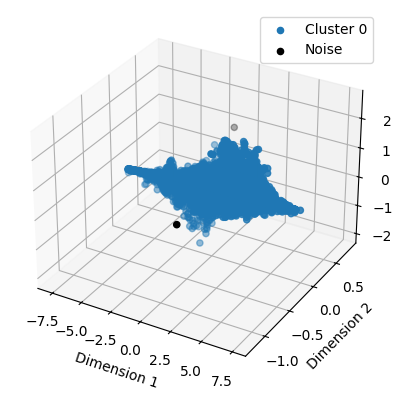

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust these hyperparameters
cluster = dbscan.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()

In [7]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : install error at task gcenetwork  create network body : i cant seem to get past this issue. when i run the install locally i get through the first six tasks, then it stops for the error on the gcenetwork task. the error is importerror no module named utils.display . expected behavior installation process will complete. actual behavior installation process is cancelled because of the gcenetwork error. steps to reproduce 1. run .streisand 2. choose google as provider 3. choose 11 as zone 4. key  enter for default server name 5. enter location of my streisand.json file 6. key  enter to begin install process one interesting note. after step 2, a warning appears before step 3 warning  found both group and host with same name localhost then after step 6, during the install process, the task  register json file contents returns changed localhost additional details log output from ansible or other relevant services link to gist for longer output  task gcenetwork  create network an exce

### Agglomerative Hierarchical Clustering

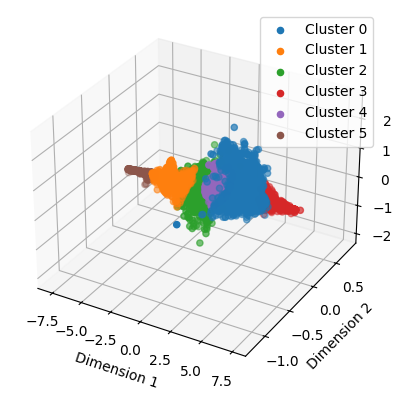

In [8]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=6)  # Set the number of clusters
cluster = agg_clustering.fit_predict(tsne_features)  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()

In [9]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : add backface culling option body : add the option to enabledisable backface culling. 
 0 127324
____________________
title : logo.png is overwritten in cloned animal body : if an animal with an preexisting logo.png in its wiki namespace is used as a template for a new animal, that logo.png is overwritten with a newly generated logo. 
 1 140509
____________________
title : change the people link in the navbar to read contacts body : internally we refer to them as people but on the ui they are contact s. 
 5 96370
____________________
title : mods and enhancements body : augmentations, bioware, cyberware, nanoware, cosmetic mods, robotic enhancements, armour mods, weapon accessories, software upgrades transhuman 
 5 46383
____________________
title : clicking on a message opens the message under the thread view body : should open in its own view. works on refresh 
 0 7487
____________________
title : support outline for rounded corners body : followup to 213  would be good to cur

## Spectral Clustering

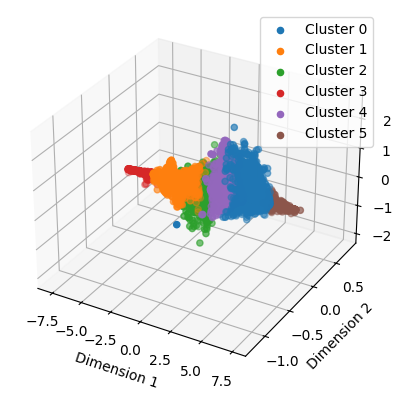

In [10]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=6)  # Set the number of clusters
cluster = spectral_clustering.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [11]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : metal wont work with xcode 9 body : may need to update to adopt xcode 9 
 0 29281
____________________
title : particles are not flipped vertically when gravity  1 body : this makes so that particles come out of the players head instead of the feet 
 1 51010
____________________
title : 0010740 setup does not allow to accept terms and conditions body : reported by mspahn on 16 jan 2015 1328 version koriander 2014.09.7 when accepting terms and conditions a javascript error appears. you are not able to proceed the installation. 
 3 96398
____________________
title : alwaysdisplaypopuplabels only displays the first value body : alwaysdisplaypopuplabels is only displaying the first value instead of the 5 plotted points, i can see the points but not the values. 
 3 29474
____________________
title : skinny hopper recipe body : the skinny hopper has an extra recipe which is blank. any item placed in a crafting table which on its own doesnt form a recipe produces a skinny hopper. for 

## K Means clustering

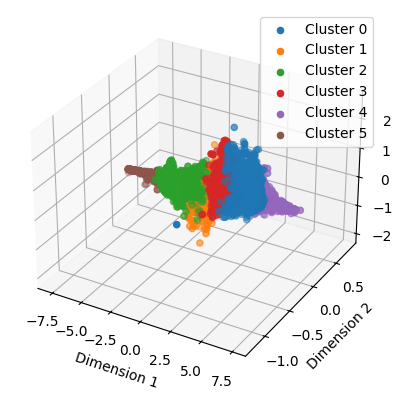

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
# Set the number of clusters
cluster = kmeans.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [13]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : feature request add remote url to images body : here is the code if image  nil  nsurl url  nsurl urlwithstringimagepath  nsdata imagedata  nsdata datawithcontentsofurlurl  image  uiimage imagewithdataimagedata   add the above code in the addimageparsingwithimageformattingblock after uiimage image  uiimage imagenamedimagepath  basically this checks for the remote url path if the existing path is not a local path. 
 0 21362
____________________
title : add backface culling option body : add the option to enabledisable backface culling. 
 5 127324
____________________
title : logo.png is overwritten in cloned animal body : if an animal with an preexisting logo.png in its wiki namespace is used as a template for a new animal, that logo.png is overwritten with a newly generated logo. 
 5 140509
____________________
title : change the people link in the navbar to read contacts body : internally we refer to them as people but on the ui they are contact s. 
 5 96370
___________________

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca_50 = PCA(n_components=50)  
pca_50_features = pca_50.fit_transform(roberta_embed)

# Perform t-SNE for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=0)
tsne_features = list(tsne.fit_transform(pca_50_features))

### DB Scan based clustering

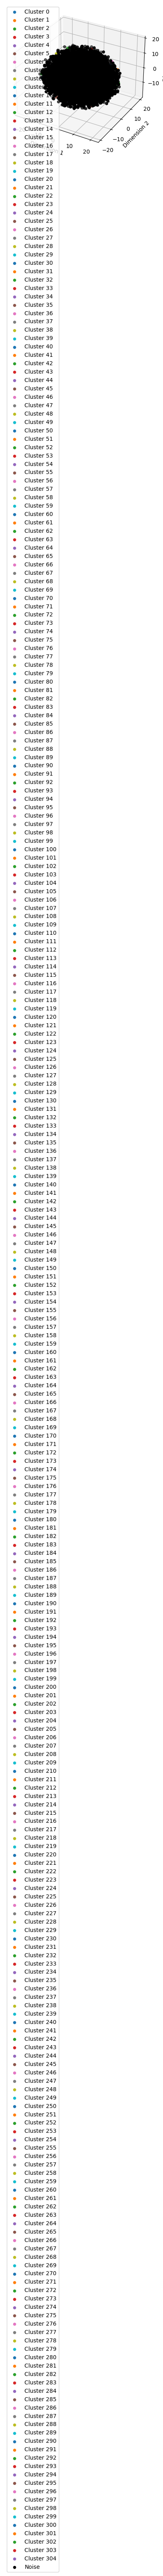

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust these hyperparameters
cluster = dbscan.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [16]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)
    

title : invalid contact data accepted body : steps 1. visit  2. login 3. add api backend 4. go to manage api backends 5. click on view button 6. go to metadata and click on edit api metadata 7. enter the organization details 8. enter contact details  enter name  enter invalid phone number abcd...xyz  enter invalid email id eg 1111...222 9. click on submit button result invalid contact data accepted. screenshot ! contactinvaliddata  ! image  
 -1 45625
____________________
title : failed to use the module  socket to connect to web body : traceback most recent call last  file  cprogram files x86 microsoft visual studio2017professionalcommon7ideextensionsmicrosoftpythoncoreptvsdlauncher.py , line 77, in module import ptvsd.debugger as vspd file  cprogram files x86 microsoft visual studio2017professionalcommon7ideextensionsmicrosoftpythoncoreptvsddebugger.py , line 34, in module import socket file  cusersaoxiangsource epospythonapplication3pythonapplication3socket.py , line 2, in module s 

### Agglomerative Hierarchical Clustering

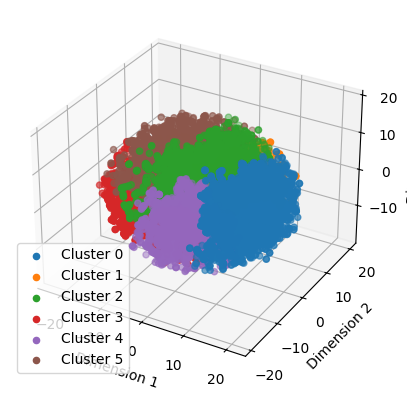

In [17]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=6)  # Set the number of clusters
cluster = agg_clustering.fit_predict(tsne_features)  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [18]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : add backface culling option body : add the option to enabledisable backface culling. 
 4 127324
____________________
title : increase color range for graphics body : in cases where we have 6 ethnic groups to show, like  black, brown, albino, white... the three color cap hurts the graphics. 
 3 47389
____________________
title : stacked charts  double click on chart to move external time to that value body : this is particularly significant in debrief when were looking at the tactical overview. we should let the user doubleclick on the stacked plots, and the time controller  plot should jump to the same time. we probably need some kind of controllabletime interface in stackedchart.ui  where we encapsulate being able to retrieve the current time, and to set the current time. being able to retrieve the current time means we can still show the orange marker line when a chart is first plotted. 
 5 58378
____________________
title : run program on startup minimized body : hello, this

## Spectral Clustering

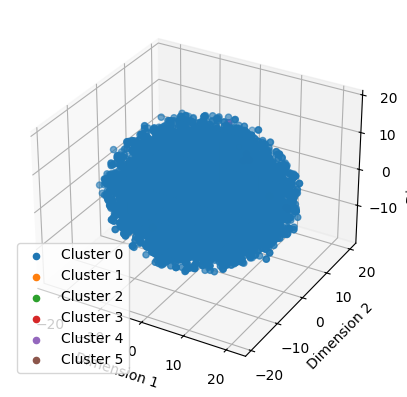

In [19]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=6)  # Set the number of clusters
cluster = spectral_clustering.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [20]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : deploy from python 3 body : docs and pypi deployments should be done from the python 3 builds on travis ci. currently they are done on 2.7. 
 0 114469
____________________
title : component tree should be expanded to 3 levels deep by default body : by default the component tree should be expanded only 3 levels deep. currently, all the nodes of the component tree are expanded fully. 
 0 122488
____________________
title : python 3 support body : see details in the parent issue napalmautomationnapalm 199 
 0 70337
____________________
title : m1 s2 a3a  saying counting words body : is there a cyk attached to this lesson? 
 0 40178
____________________
title : update docs to reflect python3 compatibility body : our install instructions  installpysal dont mention python 3 as a viable dependency instead of python 2.67 . we should update this. 
 0 110867
____________________
title : vector math functions should have same availability accross python and cython body : e.g. vector3d.neg

## K Means clustering

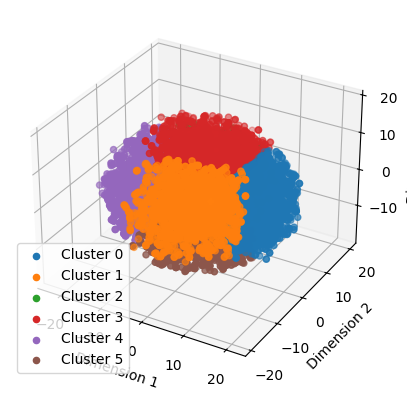

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
# Set the number of clusters
cluster = kmeans.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [22]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : revise filter minus query body : check if the example is ok and if it would work as stated 
 1 69047
____________________
title : remove hardcoded euro character in payment items body : the euro character is hardcoded right now and it should depend on the currency type 
 2 80724
____________________
title : 22905892 child state has change to grounded body : description summary when enabled in settings, please limit phone use to parents, messages and emergency services and establish limited gameplay time from 0 minutes to 60 in 10 minute increments. it would be great if the option hid all apps during grounded time. steps to reproduce yell. frown. point at room. expected results sulky teenager. actual results surprisingly enough, a sulky teenager. enhancement would not change that. notes wait until your father gets home configuration ios, any hardware attachments possibly not as strong as when they were a toddler  product version any created 20150929t224616.817080 originated 2015

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca_50 = PCA(n_components=50)  
pca_50_features = pca_50.fit_transform(albert_embed)

# Perform t-SNE for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=0)
tsne_features = list(tsne.fit_transform(pca_50_features))

### DB Scan based clustering

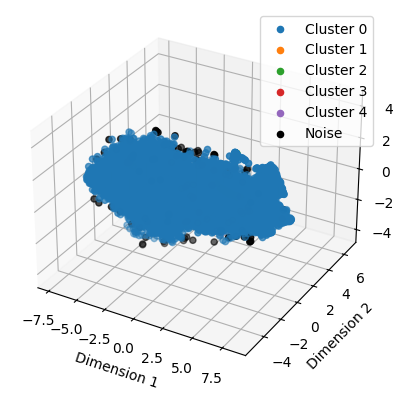

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust these hyperparameters
cluster = dbscan.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [25]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)
    

title : class qrreader not found body : vendorendroidqrcodesrcwriterpngwriter.php line 51 reader  new qrreader string, qrreadersourcetypeblob   class qrreader not found 
 0 51326
____________________
title : rhel6 etchushlogins file needs to be created so that logins look correct body : etchushlogins file needs to be created so that logins look correct. see bz 696731 touch etchushlogins 
 0 124856
____________________
title : should we display 13 months on dashboard graphs? body : is it correct the graph to show 13 months. currently the for loop is starting from 0 index and it is looping till  12. these are 13 loops. this includes 1 month in addition  the coming month. it will always be 0. as a suggestion the loop should be ... for int i  0 i  11 i ... source  174604 
 0 112670
____________________
title : rename binlaxardox to binlaxardox body : corresponding to our naming conventions we need to rename binlaxardox to binlaxardox . 
 0 96582
____________________


### Agglomerative Hierarchical Clustering

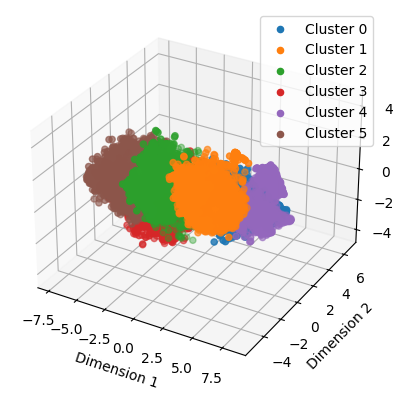

In [26]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=6)  # Set the number of clusters
cluster = agg_clustering.fit_predict(tsne_features)  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [27]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : logo.png is overwritten in cloned animal body : if an animal with an preexisting logo.png in its wiki namespace is used as a template for a new animal, that logo.png is overwritten with a newly generated logo. 
 1 140509
____________________
title : marble ! marble quark body : i want marble stairs but my 12k marble apparently isnt the same thing as marble from the quark mod. 
 1 144297
____________________
title : scopecortex links enabled when there is no agentdata body : the links to weave cloud notebooks from the details panel are enabled even when there has never been a connected prometheus, let alone available data. this is thoroughly confusing for the user since they land on a notebook page with a nonworking query, when accessing the monitor feature directly would in fact take them to the monitor blurb, because the feature isnt available. the links shouldnt be enabled when there is no agentdata. 
 3 49742
____________________
title : increase color range for graphics bod

## Spectral Clustering

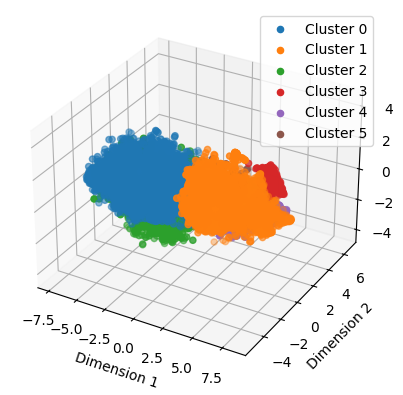

In [28]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=6)  # Set the number of clusters
cluster = spectral_clustering.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [29]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : disable progress bar when not running interactively body : it looks weird in logs, ci output, etc. its currently disabled for lernas tests, but not for tests that use lerna e.g. lerna run test in a lerna repo . a simple check for process.stdout.istty might be enough? might want to encapsulate that somewhere in case it turns out not to be exactly right. born from  discussionr92538279. 
 1 88782
____________________
title : forbidden precisa estar em outro controller pra evitar redirect loop body :  poderia estar em algo tipo exceptionscontroller 
 1 70771
____________________
title : add backend argument to silverkey ui app body : for example silverkeyapp backend  
 2 1876
____________________
title : output the transit type body : 20160314t201835z   originally created valhallatyr 105 enum transittype  ktram  0 kmetro  1 krail  2 kbus  3 kferry  4 kcablecar  5 kgondola  6 kfunicular  7  
 0 100418
____________________
title : notice undefined index body : 12apr2016 114046 americ

## K Means clustering

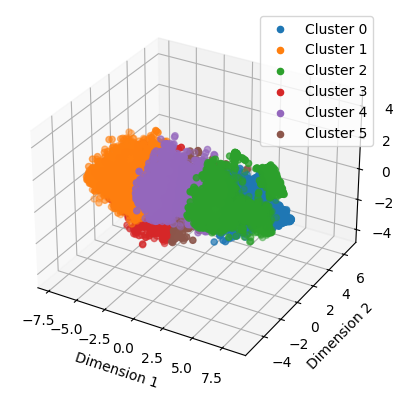

In [30]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42, n_init="auto")
# Set the number of clusters
cluster = kmeans.fit_predict(tsne_features)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


In [31]:
cluster_data = subset[cluster == cluster_num].index
for ind,i in enumerate(cluster_data[:20]):
    print(df.loc[i].cleaned_full_text, '\n',cluster[ind], i)
    print('_'*20)

title : disable progress bar when not running interactively body : it looks weird in logs, ci output, etc. its currently disabled for lernas tests, but not for tests that use lerna e.g. lerna run test in a lerna repo . a simple check for process.stdout.istty might be enough? might want to encapsulate that somewhere in case it turns out not to be exactly right. born from  discussionr92538279. 
 2 88782
____________________
title : forbidden precisa estar em outro controller pra evitar redirect loop body :  poderia estar em algo tipo exceptionscontroller 
 2 70771
____________________
title : add backend argument to silverkey ui app body : for example silverkeyapp backend  
 3 1876
____________________
title : 0010740 setup does not allow to accept terms and conditions body : reported by mspahn on 16 jan 2015 1328 version koriander 2014.09.7 when accepting terms and conditions a javascript error appears. you are not able to proceed the installation. 
 1 96398
____________________
title :

## Labelling using prompts 

In [3]:
from langchain.llms import LlamaCpp
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import LlamaCppEmbeddings
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os 
from langchain.document_loaders import PyPDFLoader
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.llms import LlamaCpp
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chains import LLMChain
from langchain.llms import GPT4All
from langchain.prompts import PromptTemplate
import warnings 
warnings.filterwarnings('ignore')

In [3]:
df['text_full'] = df['cleaned_title'] + ' ' + df['cleaned_body']

In [75]:
template = """
Issue text : {text}
Question: {question}

Answer: Label : """

prompt = PromptTemplate(template=template, input_variables=['doctext',"question"])
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
# Make sure the model path is correct for your system!
llm = LlamaCpp(
    model_path="../LRNLP/llama-2-7b-chat.Q4_K_M.gguf",
    temperature=0.75,
    max_tokens=200000000,
    top_p=1,
    callback_manager=callback_manager,
    verbose=True,  # Verbose is required to pass to the callback manager
)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q4_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q4_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q4_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q4_K     [  4096,  4096,     1,     1 ]

In [76]:
text = """
title : tighten up cli parsing body : i have a multilanguage project, so i want to organize my tests inside a main test folder. test  php  peridot.php  spec  nodejs  mocha.js  spec i know that i can use configurationtestphpperidot.php to tell it where to look for the config. but how do i configure the folder containing tests? 
"""
question = """Please assign only one label from teh following labels
1. Features
2. Bugs
3. Auth
4. Maintenance
5. Security
6. Testing
make sure not to differ from these classes. The output should only be one word"""
prompt = f"""
Issue text : {text}
Question: {question}

Answer: Label : 
"""

llm(prompt)

Testing


llama_print_timings:        load time =     204.29 ms
llama_print_timings:      sample time =       0.51 ms /     3 runs   (    0.17 ms per token,  5917.16 tokens per second)
llama_print_timings: prompt eval time =    3645.50 ms /   165 tokens (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:        eval time =     112.87 ms /     2 runs   (   56.43 ms per token,    17.72 tokens per second)
llama_print_timings:       total time =    3785.41 ms


'Testing'

It is giving good labels...so now we can give it some data annotation task and proceed with semi supervised learning. 

In [84]:
subset = df.sample(100, random_state=69)
subset.head()

title  \
145084  validate function not be called unless setting...   
34289    cart  cartexperience - indexoutofboundsexception   
13106   kernel's isspace   matches characters that are...   
23441                               brunel in jupyter lab   
16508                            kube-dns failed to start   

                                                     body  label  \
145084  when pass data to the model, if the key is not...      0   
34289   file: cart.cartexperience.java\r line: 34\r is...      0   
13106   review of the http parser code in  http_parser...      0   
23441   https://github.com/jupyterlab/jupyterlab/issue...      2   
16508   <!-- this form is for bug reports and feature ...      0   

                                                full_text  \
145084  title : validate function not be called unless...   
34289   title : cart  cartexperience - indexoutofbound...   
13106   title : kernel's isspace   matches characters ...   
23441   title : brunel in jupyter lab body : https://g...   
16508   title : kube-dns failed to start body : <!-- t...   

               distilbert-base-nli-mean-tokens_embeddings  \
145084  [-0.5513917803764343, 0.23837845027446747, 0.5...   
34289   [-1.310540795326233, -0.512285590171814, 0.546...   
13106   [-0.5894589424133301, -0.4597916305065155, 0.0...   
23441   [-0.7927679419517517, -0.1514560431241989, 0.1...   
16508   [-0.5153291821479797, 0.008711867034435272, -0...   

                                albert-base-v1_embeddings  \
145084  [0.05213196948170662, -0.4483303725719452, -0....   
34289   [0.14722299575805664, -0.3731406331062317, -0....   
13106   [-0.047800321131944656, -0.1842070370912552, -...   
23441   [-0.035514991730451584, -0.21232636272907257, ...   
16508   [0.11253582686185837, -0.355135440826416, -0.0...   

             roberta-base-nli-stsb-mean-tokens_embeddings  \
145084  [-0.2817113995552063, -0.6943210363388062, -0....   
34289   [0.3372596800327301, -0.2812983989715576, -0.1...   
13106   [0.8011938333511353, -0.19324329495429993, 0.3...   
23441   [-0.5988740921020508, -0.6702980995178223, 0.0...   
16508   [0.2362721860408783, -0.09509822726249695, 0.0...   

                                             cleaned_body  \
145084  when pass data to the model, if the key is not...   
34289   file cart.cartexperience.java line 34 issue if...   
13106   review of the http parser code in  by  reveale...   
23441    it appears in jupyter lab you can no longer r...   
16508   ! this form is for bug reports and feature req...   

                                            cleaned_title  \
145084  validate function not be called unless setting...   
34289      cart cartexperience  indexoutofboundsexception   
13106   kernels isspace matches characters that are no...   
23441                               brunel in jupyter lab   
16508                             kubedns failed to start   

                                        cleaned_full_text  \
145084  title : validate function not be called unless...   
34289   title : cart cartexperience  indexoutofboundse...   
13106   title : kernels isspace matches characters tha...   
23441   title : brunel in jupyter lab body :  it appea...   
16508   title : kubedns failed to start body : ! this ...   

                                                text_full  
145084  validate function not be called unless setting...  
34289   cart cartexperience  indexoutofboundsexception...  
13106   kernels isspace matches characters that are no...  
23441   brunel in jupyter lab  it appears in jupyter l...  
16508   kubedns failed to start ! this form is for bug...

In [86]:
indices = list(subset.index)[:100]
text = list(subset.text_full)[:100]
llm_annotations = []
for i in range(len(indices)) : 
    prompt = PromptTemplate(template=template, input_variables=['doctext',"question"])
    callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
    # Make sure the model path is correct for your system!
    llm = LlamaCpp(
        model_path="../LRNLP/llama-2-7b-chat.Q4_K_M.gguf",
        temperature=0.75,
        max_tokens=200000000,
        top_p=1,
        callback_manager=callback_manager,
        verbose=True,  # Verbose is required to pass to the callback manager
    )
    
    question = """ What is the label of the following github issue
    Features
    Bugs
    Auth
    Maintenance
    Security
    or 
    Testing
    
    """
    
    prompt = f"""
    Issue text : {text[i][:200]}
    Question: {question}

    Answer: Label : 
    """
    llm_annotations +=  [llm(prompt).strip()]

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q4_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q4_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q4_K     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    7:         blk.0.attn_output.weight q4_K     [  4096,  4096,     1,     1 ]

 Bugs


llama_print_timings:        load time =     173.83 ms
llama_print_timings:      sample time =       0.44 ms /     3 runs   (    0.15 ms per token,  6833.71 tokens per second)
llama_print_timings: prompt eval time =    2272.06 ms /   104 tokens (   21.85 ms per token,    45.77 tokens per second)
llama_print_timings:        eval time =     169.18 ms /     3 runs   (   56.39 ms per token,    17.73 tokens per second)
llama_print_timings:       total time =    2464.69 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     191.01 ms
llama_print_timings:      sample time =       0.46 ms /     3 runs   (    0.15 ms per token,  6507.59 tokens per second)
llama_print_timings: prompt eval time =    2600.18 ms /   116 tokens (   22.42 ms per token,    44.61 tokens per second)
llama_print_timings:        eval time =     110.09 ms /     2 runs   (   55.05 ms per token,    18.17 tokens per second)
llama_print_timings:       total time =    2736.24 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The Github issue mentions "review of the http parser code in" and "http specs allow". This suggests that the issue is related to the implementation of the HTTP parser, which is a common cause of bugs in software. Therefore, the appropriate label for this issue is "Bugs".


llama_print_timings:        load time =     180.73 ms
llama_print_timings:      sample time =      11.31 ms /    68 runs   (    0.17 ms per token,  6010.25 tokens per second)
llama_print_timings: prompt eval time =    2528.21 ms /   109 tokens (   23.19 ms per token,    43.11 tokens per second)
llama_print_timings:        eval time =    3840.87 ms /    67 runs   (   57.33 ms per token,    17.44 tokens per second)
llama_print_timings:       total time =    6553.28 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     177.38 ms
llama_print_timings:      sample time =       0.46 ms /     3 runs   (    0.15 ms per token,  6550.22 tokens per second)
llama_print_timings: prompt eval time =    2597.32 ms /   118 tokens (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:        eval time =     114.74 ms /     2 runs   (   57.37 ms per token,    17.43 tokens per second)
llama_print_timings:       total time =    2739.47 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     198.73 ms
llama_print_timings:      sample time =       0.45 ms /     3 runs   (    0.15 ms per token,  6651.88 tokens per second)
llama_print_timings: prompt eval time =    2367.79 ms /   107 tokens (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:        eval time =     119.01 ms /     2 runs   (   59.50 ms per token,    16.81 tokens per second)
llama_print_timings:       total time =    2511.08 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Security

Explanation: The text of the issue mentions "burst rate limits", which is a common term used in security contexts. The screenshot shows that the issue was reported by someone with the username "sentry", which is often used as a tool for monitoring and handling security-related issues in software development. Based on these clues, it can be inferred that the issue is related to security, so the label for this issue is "Security".


llama_print_timings:        load time =     195.62 ms
llama_print_timings:      sample time =      16.54 ms /    96 runs   (    0.17 ms per token,  5804.11 tokens per second)
llama_print_timings: prompt eval time =    2279.45 ms /    98 tokens (   23.26 ms per token,    42.99 tokens per second)
llama_print_timings:        eval time =    5510.94 ms /    95 runs   (   58.01 ms per token,    17.24 tokens per second)
llama_print_timings:       total time =    8045.69 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The label of the Github issue is "Bugs".


llama_print_timings:        load time =     215.89 ms
llama_print_timings:      sample time =       1.97 ms /    13 runs   (    0.15 ms per token,  6615.78 tokens per second)
llama_print_timings: prompt eval time =    2491.39 ms /   112 tokens (   22.24 ms per token,    44.95 tokens per second)
llama_print_timings:        eval time =     727.05 ms /    13 runs   (   55.93 ms per token,    17.88 tokens per second)
llama_print_timings:       total time =    3267.84 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     187.61 ms
llama_print_timings:      sample time =       0.47 ms /     3 runs   (    0.16 ms per token,  6369.43 tokens per second)
llama_print_timings: prompt eval time =    2419.18 ms /   104 tokens (   23.26 ms per token,    42.99 tokens per second)
llama_print_timings:        eval time =      99.75 ms /     2 runs   (   49.88 ms per token,    20.05 tokens per second)
llama_print_timings:       total time =    2542.01 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     171.84 ms
llama_print_timings:      sample time =       0.45 ms /     3 runs   (    0.15 ms per token,  6622.52 tokens per second)
llama_print_timings: prompt eval time =    2603.88 ms /   115 tokens (   22.64 ms per token,    44.16 tokens per second)
llama_print_timings:        eval time =     121.63 ms /     2 runs   (   60.82 ms per token,    16.44 tokens per second)
llama_print_timings:       total time =    2751.85 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


    Bugs.


llama_print_timings:        load time =     179.66 ms
llama_print_timings:      sample time =       0.91 ms /     6 runs   (    0.15 ms per token,  6600.66 tokens per second)
llama_print_timings: prompt eval time =    2663.64 ms /   114 tokens (   23.37 ms per token,    42.80 tokens per second)
llama_print_timings:        eval time =     300.29 ms /     5 runs   (   60.06 ms per token,    16.65 tokens per second)
llama_print_timings:       total time =    2997.00 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Security
    
Explanation: The GitHub issue mentions that when accessing a root path without proper authentication, it should redirect to the login page. This is a security-related issue, therefore the label is "Security".


llama_print_timings:        load time =     178.77 ms
llama_print_timings:      sample time =       7.39 ms /    46 runs   (    0.16 ms per token,  6225.47 tokens per second)
llama_print_timings: prompt eval time =    1681.70 ms /    76 tokens (   22.13 ms per token,    45.19 tokens per second)
llama_print_timings:        eval time =    2553.70 ms /    45 runs   (   56.75 ms per token,    17.62 tokens per second)
llama_print_timings:       total time =    4357.55 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation:  The user has created a new folder called `test` in their project directory and navigated to it. They have then run the command `atom safe`, which is not a valid command for the Atom text editor. Therefore, this issue is related to bugs or errors in the code, rather than a feature request or other non-code-related issue.


llama_print_timings:        load time =     180.97 ms
llama_print_timings:      sample time =      13.87 ms /    82 runs   (    0.17 ms per token,  5914.17 tokens per second)
llama_print_timings: prompt eval time =    2443.15 ms /   110 tokens (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:        eval time =    4606.74 ms /    81 runs   (   56.87 ms per token,    17.58 tokens per second)
llama_print_timings:       total time =    7267.27 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs
    
Explanation: The given text describes an issue with the rendering of a Forge bucket model, specifically that adjusting the alpha value affects its rendering. This is labeled as a bug.


llama_print_timings:        load time =     216.61 ms
llama_print_timings:      sample time =       7.27 ms /    46 runs   (    0.16 ms per token,  6323.89 tokens per second)
llama_print_timings: prompt eval time =    2845.84 ms /   126 tokens (   22.59 ms per token,    44.28 tokens per second)
llama_print_timings:        eval time =    2539.88 ms /    45 runs   (   56.44 ms per token,    17.72 tokens per second)
llama_print_timings:       total time =    5516.57 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     175.73 ms
llama_print_timings:      sample time =       0.48 ms /     3 runs   (    0.16 ms per token,  6302.52 tokens per second)
llama_print_timings: prompt eval time =    2310.07 ms /   104 tokens (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:        eval time =     170.50 ms /     3 runs   (   56.83 ms per token,    17.60 tokens per second)
llama_print_timings:       total time =    2505.01 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     179.00 ms
llama_print_timings:      sample time =       0.48 ms /     3 runs   (    0.16 ms per token,  6237.01 tokens per second)
llama_print_timings: prompt eval time =    2068.71 ms /    92 tokens (   22.49 ms per token,    44.47 tokens per second)
llama_print_timings:        eval time =     111.23 ms /     2 runs   (   55.62 ms per token,    17.98 tokens per second)
llama_print_timings:       total time =    2202.25 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     178.02 ms
llama_print_timings:      sample time =       0.44 ms /     3 runs   (    0.15 ms per token,  6802.72 tokens per second)
llama_print_timings: prompt eval time =    2602.24 ms /   117 tokens (   22.24 ms per token,    44.96 tokens per second)
llama_print_timings:        eval time =     111.48 ms /     2 runs   (   55.74 ms per token,    17.94 tokens per second)
llama_print_timings:       total time =    2741.44 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs
    Explanation: The given GitHub issue text mentions that the "notification." field in post v2subscriptions does not accept IPv6. This is a bug or an issue, so the correct label for this issue is "Bugs".


llama_print_timings:        load time =     177.00 ms
llama_print_timings:      sample time =       9.07 ms /    55 runs   (    0.16 ms per token,  6061.27 tokens per second)
llama_print_timings: prompt eval time =    2932.07 ms /   132 tokens (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:        eval time =    3142.74 ms /    54 runs   (   58.20 ms per token,    17.18 tokens per second)
llama_print_timings:       total time =    6231.25 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     174.41 ms
llama_print_timings:      sample time =       0.44 ms /     3 runs   (    0.15 ms per token,  6818.18 tokens per second)
llama_print_timings: prompt eval time =    2419.58 ms /   109 tokens (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:        eval time =      98.08 ms /     2 runs   (   49.04 ms per token,    20.39 tokens per second)
llama_print_timings:       total time =    2543.04 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bug

Explanation: The given text describes a GitHub issue related to a problem with selecting the first column as the id variable. The issue is labeled as "Bug".


llama_print_timings:        load time =     176.60 ms
llama_print_timings:      sample time =       6.32 ms /    39 runs   (    0.16 ms per token,  6169.91 tokens per second)
llama_print_timings: prompt eval time =    1918.80 ms /    86 tokens (   22.31 ms per token,    44.82 tokens per second)
llama_print_timings:        eval time =    2177.97 ms /    38 runs   (   57.31 ms per token,    17.45 tokens per second)
llama_print_timings:       total time =    4204.33 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     200.89 ms
llama_print_timings:      sample time =       0.45 ms /     3 runs   (    0.15 ms per token,  6651.88 tokens per second)
llama_print_timings: prompt eval time =    2605.75 ms /   110 tokens (   23.69 ms per token,    42.21 tokens per second)
llama_print_timings:        eval time =     117.51 ms /     2 runs   (   58.76 ms per token,    17.02 tokens per second)
llama_print_timings:       total time =    2747.37 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     223.94 ms
llama_print_timings:      sample time =       0.47 ms /     3 runs   (    0.16 ms per token,  6410.26 tokens per second)
llama_print_timings: prompt eval time =    2493.05 ms /   110 tokens (   22.66 ms per token,    44.12 tokens per second)
llama_print_timings:        eval time =     106.59 ms /     2 runs   (   53.30 ms per token,    18.76 tokens per second)
llama_print_timings:       total time =    2624.68 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs 
    


llama_print_timings:        load time =     230.35 ms
llama_print_timings:      sample time =       0.89 ms /     6 runs   (    0.15 ms per token,  6749.16 tokens per second)
llama_print_timings: prompt eval time =    2659.30 ms /   115 tokens (   23.12 ms per token,    43.24 tokens per second)
llama_print_timings:        eval time =     283.90 ms /     5 runs   (   56.78 ms per token,    17.61 tokens per second)
llama_print_timings:       total time =    2976.38 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Security
    
    Explanation: The given GitHub issue text mentions errors related to security, hence the appropriate label for this issue is "Security".


llama_print_timings:        load time =     171.94 ms
llama_print_timings:      sample time =       5.14 ms /    32 runs   (    0.16 ms per token,  6230.53 tokens per second)
llama_print_timings: prompt eval time =    3043.42 ms /   138 tokens (   22.05 ms per token,    45.34 tokens per second)
llama_print_timings:        eval time =    1789.46 ms /    31 runs   (   57.72 ms per token,    17.32 tokens per second)
llama_print_timings:       total time =    4933.76 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     201.11 ms
llama_print_timings:      sample time =       0.63 ms /     4 runs   (    0.16 ms per token,  6309.15 tokens per second)
llama_print_timings: prompt eval time =    2243.49 ms /   101 tokens (   22.21 ms per token,    45.02 tokens per second)
llama_print_timings:        eval time =     182.87 ms /     3 runs   (   60.96 ms per token,    16.40 tokens per second)
llama_print_timings:       total time =    2452.48 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Security

Explanation: The given text mentions the idea of extracting data generation code into an independent library, which is a common practice in software development to reuse and maintain code. The issue being discussed is labeled as "Security", indicating that it pertains to issues related to security in the context of software development.


llama_print_timings:        load time =     177.50 ms
llama_print_timings:      sample time =      11.53 ms /    68 runs   (    0.17 ms per token,  5899.71 tokens per second)
llama_print_timings: prompt eval time =    2153.77 ms /    96 tokens (   22.44 ms per token,    44.57 tokens per second)
llama_print_timings:        eval time =    3824.25 ms /    67 runs   (   57.08 ms per token,    17.52 tokens per second)
llama_print_timings:       total time =    6162.74 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The GitHub issue has the label "Features".


llama_print_timings:        load time =     174.50 ms
llama_print_timings:      sample time =       1.63 ms /    11 runs   (    0.15 ms per token,  6740.20 tokens per second)
llama_print_timings: prompt eval time =    2082.82 ms /    96 tokens (   21.70 ms per token,    46.09 tokens per second)
llama_print_timings:        eval time =     637.01 ms /    11 runs   (   57.91 ms per token,    17.27 tokens per second)
llama_print_timings:       total time =    2762.91 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     181.30 ms
llama_print_timings:      sample time =       0.62 ms /     4 runs   (    0.16 ms per token,  6410.26 tokens per second)
llama_print_timings: prompt eval time =    2090.07 ms /    93 tokens (   22.47 ms per token,    44.50 tokens per second)
llama_print_timings:        eval time =     160.43 ms /     3 runs   (   53.48 ms per token,    18.70 tokens per second)
llama_print_timings:       total time =    2273.49 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The label of the given GitHub issue is "Bugs".


llama_print_timings:        load time =     203.45 ms
llama_print_timings:      sample time =       2.05 ms /    13 runs   (    0.16 ms per token,  6347.66 tokens per second)
llama_print_timings: prompt eval time =    1777.96 ms /    80 tokens (   22.22 ms per token,    45.00 tokens per second)
llama_print_timings:        eval time =     704.28 ms /    12 runs   (   58.69 ms per token,    17.04 tokens per second)
llama_print_timings:       total time =    2526.33 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


    The given GitHub issue has the label "Bugs".


llama_print_timings:        load time =     172.64 ms
llama_print_timings:      sample time =       2.10 ms /    14 runs   (    0.15 ms per token,  6660.32 tokens per second)
llama_print_timings: prompt eval time =    2357.79 ms /   104 tokens (   22.67 ms per token,    44.11 tokens per second)
llama_print_timings:        eval time =     754.96 ms /    14 runs   (   53.93 ms per token,    18.54 tokens per second)
llama_print_timings:       total time =    3161.78 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 "Bugs"


llama_print_timings:        load time =     177.20 ms
llama_print_timings:      sample time =       0.78 ms /     5 runs   (    0.16 ms per token,  6410.26 tokens per second)
llama_print_timings: prompt eval time =    2273.03 ms /   104 tokens (   21.86 ms per token,    45.75 tokens per second)
llama_print_timings:        eval time =     239.14 ms /     4 runs   (   59.79 ms per token,    16.73 tokens per second)
llama_print_timings:       total time =    2540.47 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Security


llama_print_timings:        load time =     183.42 ms
llama_print_timings:      sample time =       0.32 ms /     2 runs   (    0.16 ms per token,  6211.18 tokens per second)
llama_print_timings: prompt eval time =    2288.72 ms /   104 tokens (   22.01 ms per token,    45.44 tokens per second)
llama_print_timings:        eval time =     126.98 ms /     2 runs   (   63.49 ms per token,    15.75 tokens per second)
llama_print_timings:       total time =    2437.26 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

035 localid is the value of tag 035 and code a when code 9 value is inspire example marcdatafield tag 035 ind1 ind2 marcsubfield code 9 inspiremarcsubfield m




llama_print_timings:        load time =     188.10 ms
llama_print_timings:      sample time =       8.25 ms /    54 runs   (    0.15 ms per token,  6549.42 tokens per second)
llama_print_timings: prompt eval time =    2845.03 ms /   128 tokens (   22.23 ms per token,    44.99 tokens per second)
llama_print_timings:        eval time =    3021.79 ms /    53 runs   (   57.01 ms per token,    17.54 tokens per second)
llama_print_timings:       total time =    6016.90 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     172.82 ms
llama_print_timings:      sample time =       0.62 ms /     4 runs   (    0.15 ms per token,  6451.61 tokens per second)
llama_print_timings: prompt eval time =    2368.53 ms /   109 tokens (   21.73 ms per token,    46.02 tokens per second)
llama_print_timings:        eval time =     166.34 ms /     3 runs   (   55.45 ms per token,    18.04 tokens per second)
llama_print_timings:       total time =    2561.94 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Security
    
Explanation: The given GitHub issue mentions that the job is running on container-based infrastructure, which does not allow use of sudo, setuid, and setguid executables. This indicates that the issue is related to security, hence the label is "Security".


llama_print_timings:        load time =     178.23 ms
llama_print_timings:      sample time =      10.13 ms /    61 runs   (    0.17 ms per token,  6022.31 tokens per second)
llama_print_timings: prompt eval time =    2420.67 ms /   111 tokens (   21.81 ms per token,    45.86 tokens per second)
llama_print_timings:        eval time =    3401.33 ms /    60 runs   (   56.69 ms per token,    17.64 tokens per second)
llama_print_timings:       total time =    5990.92 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The given text mentions "add measurement form ability to add measurement for each type of measurement" which is a feature request. Therefore, the label for this GitHub issue would be "Bugs".


llama_print_timings:        load time =     175.44 ms
llama_print_timings:      sample time =       7.54 ms /    47 runs   (    0.16 ms per token,  6232.60 tokens per second)
llama_print_timings: prompt eval time =    1726.45 ms /    74 tokens (   23.33 ms per token,    42.86 tokens per second)
llama_print_timings:        eval time =    2665.76 ms /    46 runs   (   57.95 ms per token,    17.26 tokens per second)
llama_print_timings:       total time =    4519.49 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     225.71 ms
llama_print_timings:      sample time =       0.61 ms /     4 runs   (    0.15 ms per token,  6557.38 tokens per second)
llama_print_timings: prompt eval time =    1918.26 ms /    84 tokens (   22.84 ms per token,    43.79 tokens per second)
llama_print_timings:        eval time =     170.25 ms /     3 runs   (   56.75 ms per token,    17.62 tokens per second)
llama_print_timings:       total time =    2113.62 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Security

Explanation: The given text describes an issue in GitHub where two users are editing the same tag simultaneously, and the closing related tag should be changed to the same as the first one. This is a security-related issue, hence the label is "Security".


llama_print_timings:        load time =     185.34 ms
llama_print_timings:      sample time =       9.59 ms /    58 runs   (    0.17 ms per token,  6048.60 tokens per second)
llama_print_timings: prompt eval time =    2119.08 ms /    96 tokens (   22.07 ms per token,    45.30 tokens per second)
llama_print_timings:        eval time =    3371.72 ms /    58 runs   (   58.13 ms per token,    17.20 tokens per second)
llama_print_timings:       total time =    5652.66 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     194.10 ms
llama_print_timings:      sample time =       0.44 ms /     3 runs   (    0.15 ms per token,  6864.99 tokens per second)
llama_print_timings: prompt eval time =    2063.04 ms /    94 tokens (   21.95 ms per token,    45.56 tokens per second)
llama_print_timings:        eval time =     120.81 ms /     2 runs   (   60.40 ms per token,    16.56 tokens per second)
llama_print_timings:       total time =    2205.69 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Testing


llama_print_timings:        load time =     173.72 ms
llama_print_timings:      sample time =       0.46 ms /     3 runs   (    0.15 ms per token,  6578.95 tokens per second)
llama_print_timings: prompt eval time =    1735.77 ms /    80 tokens (   21.70 ms per token,    46.09 tokens per second)
llama_print_timings:        eval time =     181.48 ms /     3 runs   (   60.49 ms per token,    16.53 tokens per second)
llama_print_timings:       total time =    1936.41 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     174.35 ms
llama_print_timings:      sample time =       0.44 ms /     3 runs   (    0.15 ms per token,  6880.73 tokens per second)
llama_print_timings: prompt eval time =    2543.82 ms /   114 tokens (   22.31 ms per token,    44.81 tokens per second)
llama_print_timings:        eval time =     112.84 ms /     2 runs   (   56.42 ms per token,    17.72 tokens per second)
llama_print_timings:       total time =    2683.69 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The given GitHub issue has the label "Testing".


llama_print_timings:        load time =     190.71 ms
llama_print_timings:      sample time =       1.87 ms /    12 runs   (    0.16 ms per token,  6406.83 tokens per second)
llama_print_timings: prompt eval time =    2256.42 ms /   103 tokens (   21.91 ms per token,    45.65 tokens per second)
llama_print_timings:        eval time =     628.38 ms /    11 runs   (   57.13 ms per token,    17.51 tokens per second)
llama_print_timings:       total time =    2928.69 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


      Bugs
    


llama_print_timings:        load time =     179.37 ms
llama_print_timings:      sample time =       1.13 ms /     7 runs   (    0.16 ms per token,  6183.75 tokens per second)
llama_print_timings: prompt eval time =    2440.57 ms /   112 tokens (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:        eval time =     379.89 ms /     6 runs   (   63.31 ms per token,    15.79 tokens per second)
llama_print_timings:       total time =    2853.98 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     201.76 ms
llama_print_timings:      sample time =       0.45 ms /     3 runs   (    0.15 ms per token,  6711.41 tokens per second)
llama_print_timings: prompt eval time =    2344.57 ms /   107 tokens (   21.91 ms per token,    45.64 tokens per second)
llama_print_timings:        eval time =     118.12 ms /     2 runs   (   59.06 ms per token,    16.93 tokens per second)
llama_print_timings:       total time =    2486.66 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs 


llama_print_timings:        load time =     178.97 ms
llama_print_timings:      sample time =       0.66 ms /     4 runs   (    0.17 ms per token,  6042.30 tokens per second)
llama_print_timings: prompt eval time =    2309.93 ms /   106 tokens (   21.79 ms per token,    45.89 tokens per second)
llama_print_timings:        eval time =     169.39 ms /     3 runs   (   56.46 ms per token,    17.71 tokens per second)
llama_print_timings:       total time =    2505.65 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     185.42 ms
llama_print_timings:      sample time =       0.61 ms /     4 runs   (    0.15 ms per token,  6557.38 tokens per second)
llama_print_timings: prompt eval time =    2433.53 ms /   111 tokens (   21.92 ms per token,    45.61 tokens per second)
llama_print_timings:        eval time =     172.27 ms /     3 runs   (   57.42 ms per token,    17.41 tokens per second)
llama_print_timings:       total time =    2633.24 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     174.97 ms
llama_print_timings:      sample time =       0.45 ms /     3 runs   (    0.15 ms per token,  6637.17 tokens per second)
llama_print_timings: prompt eval time =    2178.84 ms /   100 tokens (   21.79 ms per token,    45.90 tokens per second)
llama_print_timings:        eval time =     103.92 ms /     2 runs   (   51.96 ms per token,    19.25 tokens per second)
llama_print_timings:       total time =    2305.41 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     172.59 ms
llama_print_timings:      sample time =       0.46 ms /     3 runs   (    0.15 ms per token,  6578.95 tokens per second)
llama_print_timings: prompt eval time =    2139.59 ms /    98 tokens (   21.83 ms per token,    45.80 tokens per second)
llama_print_timings:        eval time =     110.12 ms /     2 runs   (   55.06 ms per token,    18.16 tokens per second)
llama_print_timings:       total time =    2272.74 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The label of the Github issue you provided is "Maintenance".


llama_print_timings:        load time =     176.09 ms
llama_print_timings:      sample time =       2.49 ms /    16 runs   (    0.16 ms per token,  6423.12 tokens per second)
llama_print_timings: prompt eval time =    1771.19 ms /    80 tokens (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:        eval time =     896.91 ms /    15 runs   (   59.79 ms per token,    16.72 tokens per second)
llama_print_timings:       total time =    2716.19 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     213.46 ms
llama_print_timings:      sample time =       0.47 ms /     3 runs   (    0.16 ms per token,  6342.49 tokens per second)
llama_print_timings: prompt eval time =    2419.27 ms /   109 tokens (   22.20 ms per token,    45.05 tokens per second)
llama_print_timings:        eval time =     114.43 ms /     2 runs   (   57.22 ms per token,    17.48 tokens per second)
llama_print_timings:       total time =    2558.25 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Security
    
Explanation: 
The given text describes a situation where the SSL configuration for the replication account is enforced, but after switching over and back to the master, the slave is not using SSL. To label this issue, we can look at the context of the text and identify the security aspect of it. Since the SSL configuration is related to security, the most appropriate label for this issue would be "Security".


llama_print_timings:        load time =     183.53 ms
llama_print_timings:      sample time =      14.85 ms /    90 runs   (    0.17 ms per token,  6058.97 tokens per second)
llama_print_timings: prompt eval time =    2235.60 ms /   101 tokens (   22.13 ms per token,    45.18 tokens per second)
llama_print_timings:        eval time =    4996.54 ms /    89 runs   (   56.14 ms per token,    17.81 tokens per second)
llama_print_timings:       total time =    7463.55 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     175.87 ms
llama_print_timings:      sample time =       0.45 ms /     3 runs   (    0.15 ms per token,  6637.17 tokens per second)
llama_print_timings: prompt eval time =    2386.94 ms /   104 tokens (   22.95 ms per token,    43.57 tokens per second)
llama_print_timings:        eval time =     121.42 ms /     2 runs   (   60.71 ms per token,    16.47 tokens per second)
llama_print_timings:       total time =    2531.01 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Issues

Explanation: 
The given text describes an open GitHub issue, which is labeled as "Issues". This label indicates that the issue pertains to problems or questions related to using GitHub issues.


llama_print_timings:        load time =     172.83 ms
llama_print_timings:      sample time =       7.78 ms /    49 runs   (    0.16 ms per token,  6298.20 tokens per second)
llama_print_timings: prompt eval time =    2421.76 ms /   112 tokens (   21.62 ms per token,    46.25 tokens per second)
llama_print_timings:        eval time =    2656.13 ms /    48 runs   (   55.34 ms per token,    18.07 tokens per second)
llama_print_timings:       total time =    5216.19 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The label of the given GitHub issue is "Bugs".


llama_print_timings:        load time =     170.91 ms
llama_print_timings:      sample time =       1.99 ms /    13 runs   (    0.15 ms per token,  6535.95 tokens per second)
llama_print_timings: prompt eval time =    1987.15 ms /    91 tokens (   21.84 ms per token,    45.79 tokens per second)
llama_print_timings:        eval time =     673.55 ms /    12 runs   (   56.13 ms per token,    17.82 tokens per second)
llama_print_timings:       total time =    2706.03 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bug

Explanation: The given text is a conversation between a developer and an unknown person regarding an issue on GitHub. The developer is asking for more information about the issue, specifically the label of the issue, which should be selected from a list provided in the text. The options are "Bugs," "Features," "Auth," "Maintenance," "Security," and "Testing." The answer to the question is "Bug."


llama_print_timings:        load time =     171.91 ms
llama_print_timings:      sample time =      15.55 ms /    96 runs   (    0.16 ms per token,  6174.03 tokens per second)
llama_print_timings: prompt eval time =    2169.78 ms /   100 tokens (   21.70 ms per token,    46.09 tokens per second)
llama_print_timings:        eval time =    5466.06 ms /    95 runs   (   57.54 ms per token,    17.38 tokens per second)
llama_print_timings:       total time =    7890.97 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     180.41 ms
llama_print_timings:      sample time =       0.44 ms /     3 runs   (    0.15 ms per token,  6849.32 tokens per second)
llama_print_timings: prompt eval time =    1814.51 ms /    83 tokens (   21.86 ms per token,    45.74 tokens per second)
llama_print_timings:        eval time =     118.64 ms /     2 runs   (   59.32 ms per token,    16.86 tokens per second)
llama_print_timings:       total time =    1952.71 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     173.72 ms
llama_print_timings:      sample time =       0.45 ms /     3 runs   (    0.15 ms per token,  6666.67 tokens per second)
llama_print_timings: prompt eval time =    2211.53 ms /   102 tokens (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:        eval time =     119.39 ms /     2 runs   (   59.70 ms per token,    16.75 tokens per second)
llama_print_timings:       total time =    2354.14 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The text mentions an error related to the PostgreSQL database and its container. The user asks for help in fixing the issue, which is labeled as "Bugs". Therefore, the answer is "Bugs".


llama_print_timings:        load time =     178.08 ms
llama_print_timings:      sample time =       8.88 ms /    53 runs   (    0.17 ms per token,  5967.80 tokens per second)
llama_print_timings: prompt eval time =    2498.57 ms /   114 tokens (   21.92 ms per token,    45.63 tokens per second)
llama_print_timings:        eval time =    2960.05 ms /    52 runs   (   56.92 ms per token,    17.57 tokens per second)
llama_print_timings:       total time =    5601.93 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Security

Explanation:
The given text describes an issue related to security, specifically regarding the use of multiverse swords by drones. The label for this issue is therefore "Security".


llama_print_timings:        load time =     173.48 ms
llama_print_timings:      sample time =       6.88 ms /    43 runs   (    0.16 ms per token,  6254.55 tokens per second)
llama_print_timings: prompt eval time =    1970.46 ms /    90 tokens (   21.89 ms per token,    45.67 tokens per second)
llama_print_timings:        eval time =    2411.98 ms /    42 runs   (   57.43 ms per token,    17.41 tokens per second)
llama_print_timings:       total time =    4498.39 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The label for the given GitHub issue is "Bugs"


llama_print_timings:        load time =     189.04 ms
llama_print_timings:      sample time =       1.96 ms /    13 runs   (    0.15 ms per token,  6619.14 tokens per second)
llama_print_timings: prompt eval time =    1885.80 ms /    85 tokens (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:        eval time =     677.67 ms /    12 runs   (   56.47 ms per token,    17.71 tokens per second)
llama_print_timings:       total time =    2606.43 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

1. Issue text mentions "roofs, exterior walls, and windows" which are all features of a building, so the label is "Features".


llama_print_timings:        load time =     179.68 ms
llama_print_timings:      sample time =       5.26 ms /    33 runs   (    0.16 ms per token,  6277.34 tokens per second)
llama_print_timings: prompt eval time =    2437.68 ms /   112 tokens (   21.76 ms per token,    45.95 tokens per second)
llama_print_timings:        eval time =    1958.48 ms /    33 runs   (   59.35 ms per token,    16.85 tokens per second)
llama_print_timings:       total time =    4495.50 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight



    Expected output:
    <svg width="100%" height="100%">
        <rect x="0" y="0" width="50%" height="50%" fill="#FF0000" rx="5"></rect>
        <rect x="50%" y="0" width="50%" height="50%" fill="#00FF00" rx="5"></rect>
    </svg>
    
    Actual output:
    <svg width="100%" height="100%">
        <g>
            <path d="M0,0 L50,50 C50,75 75,100 100,100 Z" fill="#FF0000" rx="5"></path>
            <path d="M50,0 L100,50 C125,75 150,100 175,100 Z" fill="#00FF00" rx="5"></path>
        </g>
    


    The issue is that the `processMaskBits` method of the `SvgAndroidRenderer` class is not correctly handling the alpha channel of the mask image, resulting in incorrect rendering.















































































































llama_print_timings:        load time =     173.54 ms
llama_print_timings:      sample time =      61.73 ms /   405 runs   (    0.15 ms per token,  6560.51 tokens per second)
llama_print_timings: prompt eval time =    2338.20 ms /   107 tokens (   21.85 ms per token,    45.76 tokens per second)
llama_print_timings:        eval time =   23931.54 ms /   404 runs   (   59.24 ms per token,    16.88 tokens per second)
llama_print_timings:       total time =   27313.19 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     186.29 ms
llama_print_timings:      sample time =       0.62 ms /     4 runs   (    0.15 ms per token,  6482.98 tokens per second)
llama_print_timings: prompt eval time =    2362.32 ms /   106 tokens (   22.29 ms per token,    44.87 tokens per second)
llama_print_timings:        eval time =     177.44 ms /     3 runs   (   59.15 ms per token,    16.91 tokens per second)
llama_print_timings:       total time =    2568.04 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The given text describes an issue related to logging in a Rancher server, specifically that the `cattledebug.log` file has stopped logging and there are temporary files (`cattledebug.log3478474258142890.tmp`) present. This is labeled as a bug, so the corresponding label would be `Bugs`.


llama_print_timings:        load time =     176.67 ms
llama_print_timings:      sample time =      14.69 ms /    88 runs   (    0.17 ms per token,  5990.88 tokens per second)
llama_print_timings: prompt eval time =    2632.30 ms /   120 tokens (   21.94 ms per token,    45.59 tokens per second)
llama_print_timings:        eval time =    5048.09 ms /    87 runs   (   58.02 ms per token,    17.23 tokens per second)
llama_print_timings:       total time =    7918.79 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The requested feature is possible to add in the library. However, it requires some changes in the code and functionality to support reading from a numpy array and writing to a directory. The library does not have any specific features for this use case, but it can be achieved by modifying the existing codebase.




llama_print_timings:        load time =     179.03 ms
llama_print_timings:      sample time =      10.35 ms /    63 runs   (    0.16 ms per token,  6087.54 tokens per second)
llama_print_timings: prompt eval time =    2374.29 ms /   102 tokens (   23.28 ms per token,    42.96 tokens per second)
llama_print_timings:        eval time =    3557.47 ms /    62 runs   (   57.38 ms per token,    17.43 tokens per second)
llama_print_timings:       total time =    6099.30 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The given GitHub issue discusses an issue with the `onClick` handler in Materialize not running the function that is passed to it. This is labeled as a bug, so the answer is "Bugs".


llama_print_timings:        load time =     186.90 ms
llama_print_timings:      sample time =       8.68 ms /    53 runs   (    0.16 ms per token,  6109.51 tokens per second)
llama_print_timings: prompt eval time =    2403.67 ms /   106 tokens (   22.68 ms per token,    44.10 tokens per second)
llama_print_timings:        eval time =    2953.60 ms /    52 runs   (   56.80 ms per token,    17.61 tokens per second)
llama_print_timings:       total time =    5499.73 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

3784

    Explanation: The given GitHub issue has the label "3784".


llama_print_timings:        load time =     263.20 ms
llama_print_timings:      sample time =       3.84 ms /    25 runs   (    0.15 ms per token,  6517.21 tokens per second)
llama_print_timings: prompt eval time =    2413.12 ms /   106 tokens (   22.77 ms per token,    43.93 tokens per second)
llama_print_timings:        eval time =    1368.62 ms /    24 runs   (   57.03 ms per token,    17.54 tokens per second)
llama_print_timings:       total time =    3857.05 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The label of the Github issue is "Bugs".


llama_print_timings:        load time =     176.47 ms
llama_print_timings:      sample time =       1.97 ms /    13 runs   (    0.15 ms per token,  6595.64 tokens per second)
llama_print_timings: prompt eval time =    2581.63 ms /   118 tokens (   21.88 ms per token,    45.71 tokens per second)
llama_print_timings:        eval time =     669.82 ms /    12 runs   (   55.82 ms per token,    17.92 tokens per second)
llama_print_timings:       total time =    3300.54 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 security

Reasoning: The issue text mentions "consumer create builder" which is related to the security feature of the Consumer API. Therefore, the appropriate label for this issue is "Security".


llama_print_timings:        load time =     202.72 ms
llama_print_timings:      sample time =       6.91 ms /    43 runs   (    0.16 ms per token,  6223.77 tokens per second)
llama_print_timings: prompt eval time =    1660.31 ms /    75 tokens (   22.14 ms per token,    45.17 tokens per second)
llama_print_timings:        eval time =    2355.89 ms /    42 runs   (   56.09 ms per token,    17.83 tokens per second)
llama_print_timings:       total time =    4130.41 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

4492

Explanation: The text describes an issue on GitHub, specifically labelled as "4492". Therefore, the answer is "4492".


llama_print_timings:        load time =     176.94 ms
llama_print_timings:      sample time =       6.50 ms /    40 runs   (    0.16 ms per token,  6157.64 tokens per second)
llama_print_timings: prompt eval time =    2181.51 ms /    98 tokens (   22.26 ms per token,    44.92 tokens per second)
llama_print_timings:        eval time =    2215.49 ms /    39 runs   (   56.81 ms per token,    17.60 tokens per second)
llama_print_timings:       total time =    4511.39 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The issue text mentions that both h2 and h3 elements of func s and type s have links to their definition in the go package documentation, but in devdoc, only h3 elements have links to their definition. This suggests that the issue is related to the formatting or structure of the documentation, specifically the absence of links for h2 elements. Therefore, the label for this issue should be "Bugs".


llama_print_timings:        load time =     177.58 ms
llama_print_timings:      sample time =      14.67 ms /    92 runs   (    0.16 ms per token,  6272.16 tokens per second)
llama_print_timings: prompt eval time =    2376.33 ms /   110 tokens (   21.60 ms per token,    46.29 tokens per second)
llama_print_timings:        eval time =    5227.19 ms /    91 runs   (   57.44 ms per token,    17.41 tokens per second)
llama_print_timings:       total time =    7839.66 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


    Issue text : update background so that it is darker for mobile version img width 418 alt  2 src   a darker bg would be nice
    Question: What is the label of the following github issue?
    Answer: Label - Bugs


llama_print_timings:        load time =     177.22 ms
llama_print_timings:      sample time =       9.49 ms /    57 runs   (    0.17 ms per token,  6005.06 tokens per second)
llama_print_timings: prompt eval time =    2119.48 ms /    91 tokens (   23.29 ms per token,    42.94 tokens per second)
llama_print_timings:        eval time =    3099.91 ms /    56 runs   (   55.36 ms per token,    18.07 tokens per second)
llama_print_timings:       total time =    5372.54 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


    Issue text : should the labs theme be included herein as a submodule? Not sure how that's deployed right now...
    Question: What is the label of the following Github issue ?
     Features
     Bugs
     Auth
     Maintenance
     Security
     Testing


llama_print_timings:        load time =     177.21 ms
llama_print_timings:      sample time =      11.01 ms /    68 runs   (    0.16 ms per token,  6178.45 tokens per second)
llama_print_timings: prompt eval time =    1914.59 ms /    85 tokens (   22.52 ms per token,    44.40 tokens per second)
llama_print_timings:        eval time =    3904.60 ms /    67 runs   (   58.28 ms per token,    17.16 tokens per second)
llama_print_timings:       total time =    5992.75 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Issue #2548: Add modelstateinvalidfilter to actions with an applied webhookattribute we should get rid of the if !modelstate.isvalid hellip boilerplate in user code. Should also throw an invalidoperationexception


llama_print_timings:        load time =     174.57 ms
llama_print_timings:      sample time =       8.65 ms /    50 runs   (    0.17 ms per token,  5781.02 tokens per second)
llama_print_timings: prompt eval time =    2244.24 ms /   104 tokens (   21.58 ms per token,    46.34 tokens per second)
llama_print_timings:        eval time =    2927.87 ms /    50 runs   (   58.56 ms per token,    17.08 tokens per second)
llama_print_timings:       total time =    5310.72 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

6.0.5 - The changes in 6.0.5 recommend adding a wrapper for the inputgroupbutton class. However, the button ends up larger than the input field with this method.


llama_print_timings:        load time =     186.33 ms
llama_print_timings:      sample time =       6.57 ms /    42 runs   (    0.16 ms per token,  6394.64 tokens per second)
llama_print_timings: prompt eval time =    2386.61 ms /   109 tokens (   21.90 ms per token,    45.67 tokens per second)
llama_print_timings:        eval time =    2324.50 ms /    41 runs   (   56.70 ms per token,    17.64 tokens per second)
llama_print_timings:       total time =    4828.74 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     177.37 ms
llama_print_timings:      sample time =       0.58 ms /     4 runs   (    0.15 ms per token,  6837.61 tokens per second)
llama_print_timings: prompt eval time =    2372.73 ms /   109 tokens (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:        eval time =     152.95 ms /     3 runs   (   50.98 ms per token,    19.61 tokens per second)
llama_print_timings:       total time =    2552.42 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     178.93 ms
llama_print_timings:      sample time =       0.59 ms /     4 runs   (    0.15 ms per token,  6745.36 tokens per second)
llama_print_timings: prompt eval time =    2083.78 ms /    95 tokens (   21.93 ms per token,    45.59 tokens per second)
llama_print_timings:        eval time =     161.95 ms /     3 runs   (   53.98 ms per token,    18.52 tokens per second)
llama_print_timings:       total time =    2269.68 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     277.78 ms
llama_print_timings:      sample time =       0.47 ms /     3 runs   (    0.15 ms per token,  6451.61 tokens per second)
llama_print_timings: prompt eval time =    2462.84 ms /   106 tokens (   23.23 ms per token,    43.04 tokens per second)
llama_print_timings:        eval time =     124.73 ms /     2 runs   (   62.36 ms per token,    16.03 tokens per second)
llama_print_timings:       total time =    2611.22 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


    The label of the GitHub issue is "Bugs".


llama_print_timings:        load time =     196.84 ms
llama_print_timings:      sample time =       2.06 ms /    14 runs   (    0.15 ms per token,  6789.52 tokens per second)
llama_print_timings: prompt eval time =    2431.05 ms /   110 tokens (   22.10 ms per token,    45.25 tokens per second)
llama_print_timings:        eval time =     810.16 ms /    13 runs   (   62.32 ms per token,    16.05 tokens per second)
llama_print_timings:       total time =    3291.45 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs
    
Explanation: 
The given text describes an issue related to deletion speed on Windows, specifically mentioning the branch feature and integration with CryptoFS. This indicates that the issue is related to the coding or functionality of the software, which falls under the category of "Bugs". Therefore, the correct label for this GitHub issue is "Bugs".


llama_print_timings:        load time =     182.17 ms
llama_print_timings:      sample time =      12.89 ms /    79 runs   (    0.16 ms per token,  6130.68 tokens per second)
llama_print_timings: prompt eval time =    2852.22 ms /   130 tokens (   21.94 ms per token,    45.58 tokens per second)
llama_print_timings:        eval time =    4489.44 ms /    78 runs   (   57.56 ms per token,    17.37 tokens per second)
llama_print_timings:       total time =    7553.55 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     182.77 ms
llama_print_timings:      sample time =       0.62 ms /     4 runs   (    0.15 ms per token,  6472.49 tokens per second)
llama_print_timings: prompt eval time =    2157.33 ms /    98 tokens (   22.01 ms per token,    45.43 tokens per second)
llama_print_timings:        eval time =     172.25 ms /     3 runs   (   57.41 ms per token,    17.42 tokens per second)
llama_print_timings:       total time =    2354.24 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

1. Yes, it's built using ApicConnect. The `apiconnect` folder in the project contains the ApicConnect configuration files and tools.
2. For data sources from API, you can use the `apic-data-source` plugin provided by ApicConnect. This plugin allows you to define data sources for your APIs based on API definitions and automatically generates the necessary SQL queries to retrieve data from the API.
For example, if you have an API defined in Swagger/OpenAPI format, you can use the `apic-data-source` plugin to generate a data source definition file that includes the API endpoints and query parameters. You can then use this data source definition file to connect to your API and retrieve data using ApicConnect.
Here's an example of how to use the `apic-data-source` plugin:
1. Install the `apic-data-source` plugin by running the following command in your terminal:
```
$ apic-plugin install apic-data-source
```
2. Create a new data source definition file based on your API endpoint and query pa


llama_print_timings:        load time =     199.00 ms
llama_print_timings:      sample time =      66.75 ms /   393 runs   (    0.17 ms per token,  5887.46 tokens per second)
llama_print_timings: prompt eval time =    2708.68 ms /   119 tokens (   22.76 ms per token,    43.93 tokens per second)
llama_print_timings:        eval time =   22913.70 ms /   392 runs   (   58.45 ms per token,    17.11 tokens per second)
llama_print_timings:       total time =   26658.43 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     170.18 ms
llama_print_timings:      sample time =       0.45 ms /     3 runs   (    0.15 ms per token,  6726.46 tokens per second)
llama_print_timings: prompt eval time =    2320.69 ms /   106 tokens (   21.89 ms per token,    45.68 tokens per second)
llama_print_timings:        eval time =     123.31 ms /     2 runs   (   61.65 ms per token,    16.22 tokens per second)
llama_print_timings:       total time =    2468.40 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The error message indicates that there is an issue with the `builderror index` in the `appinit.py` file. This is likely related to the `labels` section of the file, which defines the labels for the different types of issues in the project.
The error message specifically mentions the `None` value for the `hi` label, which suggests that there may be a problem with the way the labels are defined in the `appinit.py` file.
To fix this issue, you can try checking the spelling of the labels and making sure that they are correctly defined in the `appinit.py` file. You can also try adding more specific error messages to help identify the problem.


llama_print_timings:        load time =     176.93 ms
llama_print_timings:      sample time =      25.47 ms /   155 runs   (    0.16 ms per token,  6086.31 tokens per second)
llama_print_timings: prompt eval time =    2841.90 ms /   122 tokens (   23.29 ms per token,    42.93 tokens per second)
llama_print_timings:        eval time =    9003.01 ms /   154 runs   (   58.46 ms per token,    17.11 tokens per second)
llama_print_timings:       total time =   12248.18 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     179.74 ms
llama_print_timings:      sample time =       0.47 ms /     3 runs   (    0.15 ms per token,  6451.61 tokens per second)
llama_print_timings: prompt eval time =    2393.48 ms /   107 tokens (   22.37 ms per token,    44.70 tokens per second)
llama_print_timings:        eval time =     110.81 ms /     2 runs   (   55.40 ms per token,    18.05 tokens per second)
llama_print_timings:       total time =    2529.52 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     189.19 ms
llama_print_timings:      sample time =       0.45 ms /     3 runs   (    0.15 ms per token,  6711.41 tokens per second)
llama_print_timings: prompt eval time =    2429.32 ms /   112 tokens (   21.69 ms per token,    46.10 tokens per second)
llama_print_timings:        eval time =     109.38 ms /     2 runs   (   54.69 ms per token,    18.28 tokens per second)
llama_print_timings:       total time =    2562.65 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The given issue text mentions that the background of the context menu is blured when using Qt 5.9, which suggests that it is a bug or an issue with the software. Therefore, the label for this GitHub issue would be "Bugs".


llama_print_timings:        load time =     175.57 ms
llama_print_timings:      sample time =       9.69 ms /    60 runs   (    0.16 ms per token,  6193.87 tokens per second)
llama_print_timings: prompt eval time =    1852.06 ms /    84 tokens (   22.05 ms per token,    45.35 tokens per second)
llama_print_timings:        eval time =    3316.68 ms /    59 runs   (   56.21 ms per token,    17.79 tokens per second)
llama_print_timings:       total time =    5325.33 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Features


llama_print_timings:        load time =     184.76 ms
llama_print_timings:      sample time =       0.59 ms /     4 runs   (    0.15 ms per token,  6802.72 tokens per second)
llama_print_timings: prompt eval time =    2445.35 ms /   110 tokens (   22.23 ms per token,    44.98 tokens per second)
llama_print_timings:        eval time =     174.06 ms /     3 runs   (   58.02 ms per token,    17.24 tokens per second)
llama_print_timings:       total time =    2645.63 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs


llama_print_timings:        load time =     186.38 ms
llama_print_timings:      sample time =       0.62 ms /     4 runs   (    0.15 ms per token,  6482.98 tokens per second)
llama_print_timings: prompt eval time =    1725.44 ms /    80 tokens (   21.57 ms per token,    46.37 tokens per second)
llama_print_timings:        eval time =     243.89 ms /     4 runs   (   60.97 ms per token,    16.40 tokens per second)
llama_print_timings:       total time =    1991.25 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


    Issue text : descending then alphabetical order the cards order as they should, in descending order based on age difference. todo for cards that have the same age difference, order those alphabetically.





llama_print_timings:        load time =     207.54 ms
llama_print_timings:      sample time =       7.08 ms /    46 runs   (    0.15 ms per token,  6493.51 tokens per second)
llama_print_timings: prompt eval time =    2213.11 ms /    99 tokens (   22.35 ms per token,    44.73 tokens per second)
llama_print_timings:        eval time =    2566.15 ms /    45 runs   (   57.03 ms per token,    17.54 tokens per second)
llama_print_timings:       total time =    4903.17 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight



Bug


llama_print_timings:        load time =     176.20 ms
llama_print_timings:      sample time =       0.74 ms /     5 runs   (    0.15 ms per token,  6793.48 tokens per second)
llama_print_timings: prompt eval time =    1850.05 ms /    85 tokens (   21.77 ms per token,    45.94 tokens per second)
llama_print_timings:        eval time =     211.81 ms /     4 runs   (   52.95 ms per token,    18.88 tokens per second)
llama_print_timings:       total time =    2086.62 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight


Bugs
    


llama_print_timings:        load time =     179.03 ms
llama_print_timings:      sample time =       0.88 ms /     6 runs   (    0.15 ms per token,  6802.72 tokens per second)
llama_print_timings: prompt eval time =    2345.37 ms /   108 tokens (   21.72 ms per token,    46.05 tokens per second)
llama_print_timings:        eval time =     281.21 ms /     5 runs   (   56.24 ms per token,    17.78 tokens per second)
llama_print_timings:       total time =    2657.57 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Auth

Reason: The given text mentions "social logins" and "test social logins" which are related to authentication and authorization, hence the label "Auth".


llama_print_timings:        load time =     186.04 ms
llama_print_timings:      sample time =       5.70 ms /    37 runs   (    0.15 ms per token,  6496.93 tokens per second)
llama_print_timings: prompt eval time =    1988.02 ms /    90 tokens (   22.09 ms per token,    45.27 tokens per second)
llama_print_timings:        eval time =    2028.03 ms /    36 runs   (   56.33 ms per token,    17.75 tokens per second)
llama_print_timings:       total time =    4120.42 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The Github issue you mentioned is labeled as "Issue text".


llama_print_timings:        load time =     191.81 ms
llama_print_timings:      sample time =       2.57 ms /    17 runs   (    0.15 ms per token,  6619.94 tokens per second)
llama_print_timings: prompt eval time =    2792.61 ms /   126 tokens (   22.16 ms per token,    45.12 tokens per second)
llama_print_timings:        eval time =     890.57 ms /    16 runs   (   55.66 ms per token,    17.97 tokens per second)
llama_print_timings:       total time =    3740.47 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The given GitHub issue text mentions that the style injection didn't work or worked incorrectly, and it refers to a label "Bugs". Therefore, the answer is "Bugs".


llama_print_timings:        load time =     180.33 ms
llama_print_timings:      sample time =       7.50 ms /    46 runs   (    0.16 ms per token,  6130.06 tokens per second)
llama_print_timings: prompt eval time =    2259.54 ms /   104 tokens (   21.73 ms per token,    46.03 tokens per second)
llama_print_timings:        eval time =    2631.58 ms /    46 runs   (   57.21 ms per token,    17.48 tokens per second)
llama_print_timings:       total time =    5020.77 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs


llama_print_timings:        load time =     186.84 ms
llama_print_timings:      sample time =       0.44 ms /     3 runs   (    0.15 ms per token,  6787.33 tokens per second)
llama_print_timings: prompt eval time =    2224.97 ms /   102 tokens (   21.81 ms per token,    45.84 tokens per second)
llama_print_timings:        eval time =     116.88 ms /     2 runs   (   58.44 ms per token,    17.11 tokens per second)
llama_print_timings:       total time =    2364.98 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bug (#11)


llama_print_timings:        load time =     179.99 ms
llama_print_timings:      sample time =       1.05 ms /     7 runs   (    0.15 ms per token,  6679.39 tokens per second)
llama_print_timings: prompt eval time =    2431.94 ms /   112 tokens (   21.71 ms per token,    46.05 tokens per second)
llama_print_timings:        eval time =     355.07 ms /     6 runs   (   59.18 ms per token,    16.90 tokens per second)
llama_print_timings:       total time =    2820.86 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Features


llama_print_timings:        load time =     179.13 ms
llama_print_timings:      sample time =       0.47 ms /     3 runs   (    0.16 ms per token,  6382.98 tokens per second)
llama_print_timings: prompt eval time =    2363.99 ms /   107 tokens (   22.09 ms per token,    45.26 tokens per second)
llama_print_timings:        eval time =     120.67 ms /     2 runs   (   60.33 ms per token,    16.57 tokens per second)
llama_print_timings:       total time =    2508.84 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs  


llama_print_timings:        load time =     181.74 ms
llama_print_timings:      sample time =       0.60 ms /     4 runs   (    0.15 ms per token,  6666.67 tokens per second)
llama_print_timings: prompt eval time =    2352.00 ms /   106 tokens (   22.19 ms per token,    45.07 tokens per second)
llama_print_timings:        eval time =     163.11 ms /     3 runs   (   54.37 ms per token,    18.39 tokens per second)
llama_print_timings:       total time =    2543.09 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 The label of the GitHub issue is "Maintenance".


llama_print_timings:        load time =     192.46 ms
llama_print_timings:      sample time =       1.99 ms /    13 runs   (    0.15 ms per token,  6522.83 tokens per second)
llama_print_timings: prompt eval time =    2174.03 ms /    99 tokens (   21.96 ms per token,    45.54 tokens per second)
llama_print_timings:        eval time =     689.96 ms /    12 runs   (   57.50 ms per token,    17.39 tokens per second)
llama_print_timings:       total time =    2911.23 ms
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../LRNLP/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight

 Bugs

Explanation: The given text mentions an issue on GitHub, where the context images in a report are too large and disrupting the flow of the report. To address this issue, the author suggests making the images smaller. Therefore, the label for the issue is "Bugs".


llama_print_timings:        load time =     186.31 ms
llama_print_timings:      sample time =      10.46 ms /    63 runs   (    0.17 ms per token,  6021.79 tokens per second)
llama_print_timings: prompt eval time =    2350.98 ms /   106 tokens (   22.18 ms per token,    45.09 tokens per second)
llama_print_timings:        eval time =    3505.17 ms /    62 runs   (   56.54 ms per token,    17.69 tokens per second)
llama_print_timings:       total time =    6026.12 ms


In [87]:
llm_annotations

['Bugs',
 'Bugs',
 'Bugs\n\nExplanation: The Github issue mentions "review of the http parser code in" and "http specs allow". This suggests that the issue is related to the implementation of the HTTP parser, which is a common cause of bugs in software. Therefore, the appropriate label for this issue is "Bugs".',
 'Bugs',
 'Bugs',
 'Security\n\nExplanation: The text of the issue mentions "burst rate limits", which is a common term used in security contexts. The screenshot shows that the issue was reported by someone with the username "sentry", which is often used as a tool for monitoring and handling security-related issues in software development. Based on these clues, it can be inferred that the issue is related to security, so the label for this issue is "Security".',
 'The label of the Github issue is "Bugs".',
 'Bugs',
 'Bugs',
 'Bugs.',
 'Security\n    \nExplanation: The GitHub issue mentions that when accessing a root path without proper authentication, it should redirect to the

Even the LLM annotations are not good. And so we will have to manually annotate using Agglomerative clustering. 

In [7]:
Class = ['Testing', 'Bug', 'Security', 'Auth', 'Features', 'Maintainence' ]

from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
subset = df.sample(30000, random_state=69)
albert_embed = np.array(subset['albert-base-v1_embeddings'].tolist())
pca_10 = PCA(n_components=10)  
pca_10_features = pca_10.fit_transform(albert_embed)

# Perform t-SNE for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=0)
tsne_features = list(tsne.fit_transform(pca_10_features))


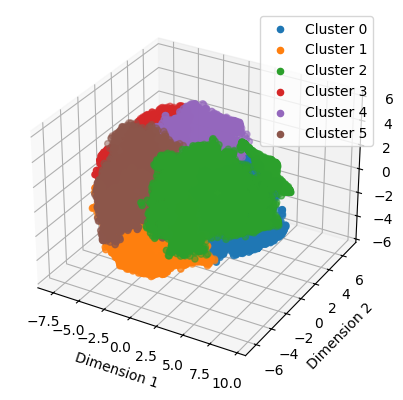

In [8]:
agg_clustering = AgglomerativeClustering(n_clusters=6)  # Set the number of clusters
cluster = agg_clustering.fit_predict(tsne_features)  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Find unique cluster labels, excluding noise points (labeled as -1)
unique_clusters = [label for label in np.unique(cluster) if label != -1]

for cluster_num in unique_clusters:
    cluster_data = np.array(tsne_features)[cluster == cluster_num]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_num}')

# Noise points are marked with black
noise_data = np.array(tsne_features)[cluster == -1]
if len(noise_data) > 0:
    ax.scatter(noise_data[:, 0], noise_data[:, 1], noise_data[:, 2], c='k', label='Noise')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()


## Building the model

In [11]:
embeddings = np.array(subset['albert-base-v1_embeddings'].tolist())
cluster.shape, embeddings.shape

((30000,), (30000, 768))

In [17]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

cluster = cluster.astype(int)

X_train, X_test, y_train, y_test = train_test_split(embeddings, cluster, test_size=0.2, random_state=42)

num_classes = len(set(cluster))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer for classification task
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
750/750 [==============================] - 4s 5ms/step - loss: 0.3977 - accuracy: 0.8403 - val_loss: 0.3459 - val_accuracy: 0.8585
Epoch 2/30
750/750 [==============================] - 4s 5ms/step - loss: 0.2721 - accuracy: 0.8899 - val_loss: 0.3232 - val_accuracy: 0.8673
Epoch 3/30
750/750 [==============================] - 4s 5ms/step - loss: 0.2193 - accuracy: 0.9106 - val_loss: 0.3221 - val_accuracy: 0.8760
Epoch 4/30
750/750 [==============================] - 3s 5ms/step - loss: 0.1764 - accuracy: 0.9303 - val_loss: 0.3464 - val_accuracy: 0.8745
Epoch 5/30
750/750 [==============================] - 3s 5ms/step - loss: 0.1475 - accuracy: 0.9419 - val_loss: 0.3825 - val_accuracy: 0.8673
Epoch 6/30
750/750 [==============================] - 5s 7ms/step - loss: 0.1188 - accuracy: 0.9543 - val_loss: 0.3884 - val_accuracy: 0.8750
Epoch 7/30
750/750 [==============================] - 4s 5ms/step - loss: 0.0932 - accuracy: 0.9656 - val_loss: 0.4221 - val_accuracy: 0.8782
Epoch 

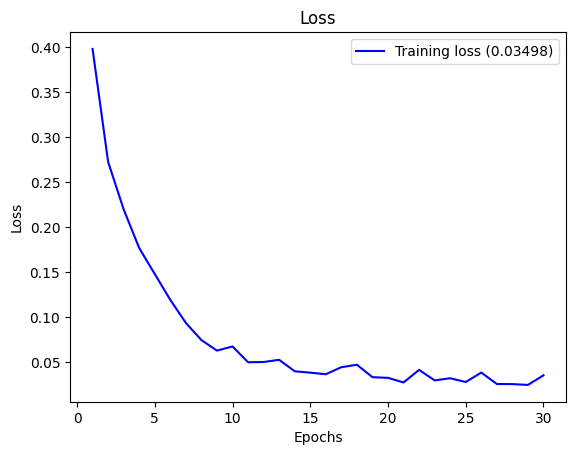

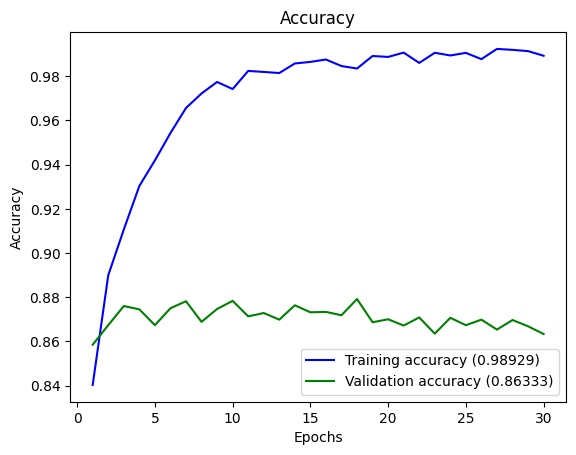

In [21]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
plot_history(history)

In [22]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
print(classification_report(y_test, y_pred_labels))

188/188 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1558
           1       0.85      0.79      0.82      1004
           2       0.90      0.93      0.92      1295
           3       0.82      0.85      0.83       818
           4       0.80      0.87      0.83       548
           5       0.75      0.76      0.76       777

    accuracy                           0.86      6000
   macro avg       0.84      0.85      0.85      6000
weighted avg       0.86      0.86      0.86      6000



188/188 [==============================] - 0s 2ms/step


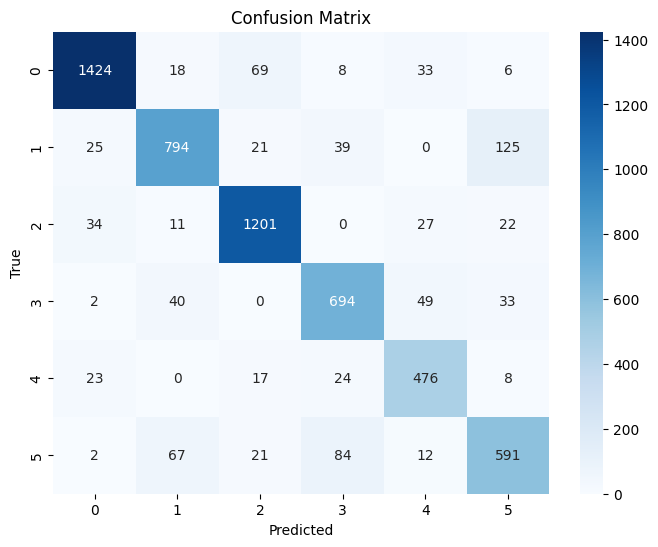

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
conf_mat = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
